In [1]:
# The survival function dist.sf(x) is just 1-dist.cdf(x). It's used in
# calculating the probability of a value being greater than a certain
# value. When do we need those? Often when the data is incomplete. For
# example, if we run a clinic trial and want to measure the survival
# time of patients. During the limited time window we run the test, we
# will have a number of survived patients and dead patients. But we
# don't know how long those survived patients will live after the
# test. The only thing we can say about is that their survival time is
# larger than T_end - T_start. This is when we need the survival
# function - it spits out a probability for duration larger than a
# given duration, which is used as likelihood to update our belief.

# This chapter makes simple use of Weibull distribution, which
# is used to model the failure rate of a system. Given random variable
# X as the "time-to-failure", the failure rate is modeled by the pdf.
# This distribution has two parameters, k and lambda. k<1 means the
# failure rate decreases over time, k>1 means the failure rate
# increases over time, and k=1 means the failure rate remains
# constant. lambda is called the scale parameter that controls the
# spreading of the distribution.

In [2]:
%load_ext autoreload
# so I can change utils.py without reloading manually
%autoreload 3

In [3]:
from scipy.stats import weibull_min

def weibull(lam, k):
    return weibull_min(k, scale=lam)

lam = 3
k = 0.8
actual_dist = weibull(lam, k)
actual_dist.rvs(10)

array([ 1.6633557 , 14.84671027,  6.23151416,  1.09262102,  3.06366001,
        1.61250869,  0.0287324 ,  2.18786345, 14.1225411 ,  3.93659491])

In [4]:
# the case study in this chapter is around running a dog shelter. Where dogs come and adopted at
# interval that is assumed to follow a weibull distribution.
# Suppose you decide to make an observation for 8 day period and take a note on all dogs coming
# and adopted. The goal is to find out the lambda and k parameter of the weibull distribution.

from utils import Pmf
import pandas as pd
import numpy as np

N = 20
start = np.random.uniform(0, 8, size=N)
duration = actual_dist.rvs(N)
end = start + duration

d = dict(start=start, end=end)
obs = pd.DataFrame(d)

In [5]:
censored = obs['end'] > 8
obs.loc[censored, 'end'] = 8
obs.loc[censored, 'status'] = 0
obs['T'] = obs['end'] - obs['start']
obs

,start,end,status,T
0,5.495122,5.716690,NaN,0.221568
1,1.922638,2.644521,NaN,0.721883
2,5.819557,8.000000,0.0,2.180443
3,2.063501,8.000000,0.0,5.936499
4,4.540116,5.759390,NaN,1.219274
5,6.549568,8.000000,0.0,1.450432
6,1.189329,1.931892,NaN,0.742563
7,7.886307,8.000000,0.0,0.113693
8,0.953608,1.142780,NaN,0.189171
9,3.394760,7.513343,NaN,4.118583


In [6]:
uncensored_data = obs.loc[~censored, 'T']
censored_data   = obs.loc[ censored, 'T']

uncensored_data, censored_data

(0     0.221568
 1     0.721883
 4     1.219274
 6     0.742563
 8     0.189171
 9     4.118583
 10    0.403499
 12    1.956381
 13    0.940453
 14    2.176966
 15    0.972403
 16    1.140851
 17    0.504289
 Name: T, dtype: float64,
 2     2.180443
 3     5.936499
 5     1.450432
 7     0.113693
 11    1.382877
 18    1.516497
 19    3.120199
 Name: T, dtype: float64)

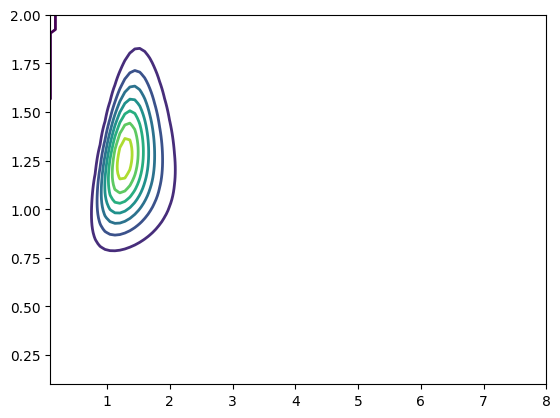

In [7]:
from utils import make_joint, marginal, plot_contour, normalize_joint

def update_uncensored(prior, data):
    lam_mesh, k_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, data)
    probs = weibull(lam_mesh, k_mesh).pdf(data_mesh)
    likelihood = probs.prod(axis=2)
    posterior = normalize_joint(prior * likelihood)
    return posterior

def update_censored(prior, data):
    lam_mesh, k_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, data)
    probs = weibull(lam_mesh, k_mesh).sf(data_mesh)
    likelihood = probs.prod(axis=2)
    posterior = prior * likelihood
    return normalize_joint(posterior)

lam_qs = np.linspace(0.1, 8.0, 101)
k_qs = np.linspace(0.1, 2.0, 101)
joint = make_joint
prior = make_joint(Pmf(1, lam_qs), Pmf(1, k_qs))
posterior1 = update_uncensored(prior, uncensored_data)
plot_contour(posterior1)

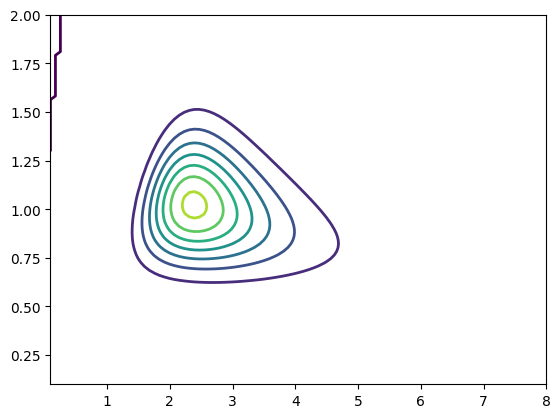

In [8]:
posterior2 = update_censored(posterior1, censored_data)
plot_contour(posterior2)

In [9]:
from utils import normalize_pmf

lam_pmf = normalize_pmf(marginal(posterior2, 0))
k_pmf = normalize_pmf(marginal(posterior2, 1))
(lam_pmf.max_prob(), k_pmf.max_prob())

(2.391, 0.955)

In [10]:
# case study 2: light bulb lifetime  
# This case study has the same idea. It showcased some fancy pandas dataframe manipulations.
# But the basic principles are the same.
!test -f data/lamps.csv || wget -O data/lamps.csv https://gist.githubusercontent.com/epogrebnyak/7933e16c0ad215742c4c104be4fbdeb1/raw/c932bc5b6aa6317770c4cbf43eb591511fec08f9/lamps.csv

In [11]:
df = pd.read_csv('data/lamps.csv', index_col=0)
df.head()

,h,f,K
i,,,
0,0,0,50
1,840,2,48
2,852,1,47
3,936,1,46
4,960,1,45


In [12]:
data = np.repeat(df['h'], df['f'])
len(data)

50

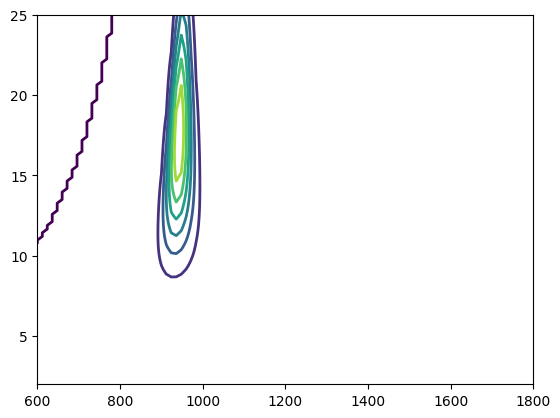

In [13]:
uncensored = data[data < 1000]
censored = [1000] * len(data[data > 1000])

lam_qs = np.linspace(600, 1800, 101)
k_qs = np.linspace(2, 25, 101)
joint = make_joint
prior = make_joint(Pmf(1, lam_qs), Pmf(1, k_qs))
posterior1 = update_uncensored(prior, uncensored)
plot_contour(posterior1)

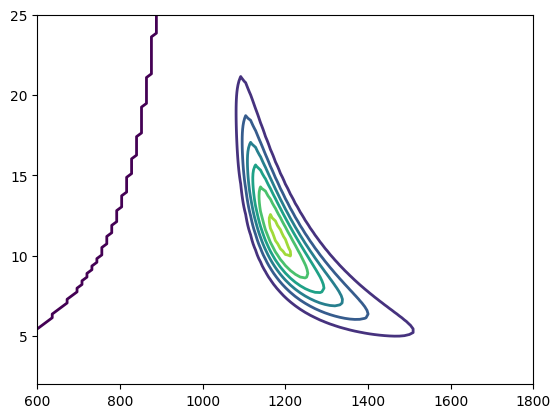

In [14]:
posterior2 = update_censored(posterior1, censored)
plot_contour(posterior2)

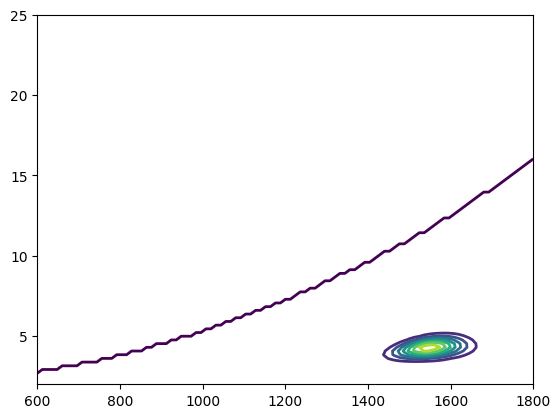

In [15]:
posterior_real = update_uncensored(prior, data)
plot_contour(posterior_real)

In [36]:
# What's the expected number of dead bulb after 1000 hours if we start from 100 light bulbs?
from scipy.stats import binom

posterior_series = Pmf(normalize_joint(posterior2).stack())

def remaining_bulbs(q):
    k, lam = q
    prob_dead = weibull(lam, k).cdf(1000)
    qs_k = np.arange(0, 101)
    return Pmf(binom.pmf(qs_k, 100, prob_dead), qs_k)

pred = posterior_series.bind(remaining_bulbs)
pred.normalize()

0.9999999999999986

(12, 13.713554377034876)

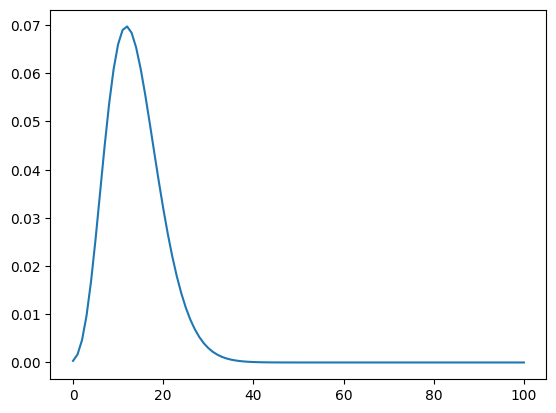

In [40]:
pred.plot()
(pred.idxmax(), pred.mean())

600.0     4.543255e-79
612.0     2.183361e-75
624.0     6.355231e-72
636.0     1.162817e-68
648.0     1.383351e-65
              ...     
1752.0    4.246108e-03
1764.0    4.185151e-03
1776.0    4.124565e-03
1788.0    4.064192e-03
1800.0    4.003879e-03
Length: 101, dtype: float64

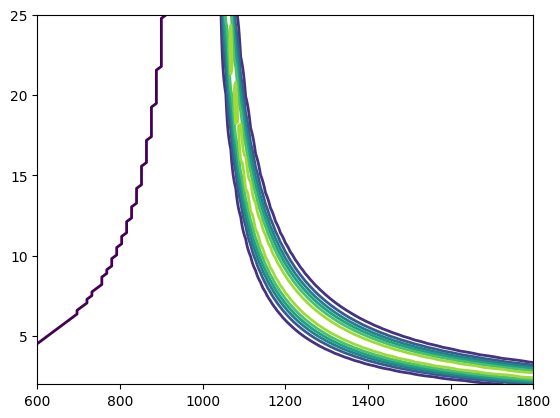

In [45]:
# Exercise 14-1: suppose you install 100 light bulb, come back after 1000 hr, and found 20 dead bulb. Compute the posterior distribution for k and lambda based on the data.
lam_qs = np.linspace(600, 1800, 101)
k_qs = np.linspace(2, 25, 101)
prior = make_joint(Pmf(1, lam_qs), Pmf(1, k_qs))

lam_mesh, k_mesh = np.meshgrid(lam_qs, k_qs)
prob_dead = weibull(lam_mesh, k_mesh).cdf(1000)
likelihoods = binom.pmf(20, 100, prob_dead)

posterior = prior * likelihoods
plot_contour(posterior)

In [ ]:
# Exercise 14-2: instruction unclear, the data is also not provided. I don't see how to start.